In [1]:
%matplotlib inline

from __future__ import division
import os
import sys
from scipy import integrate, optimize

from scipy.interpolate import interp2d, interp1d

import numpy as np
from numpy import pi,sin,cos,tan,e,arctan,arcsin,arccos,sqrt
from numpy.random import randn
import matplotlib
import matplotlib.pyplot as P
from time import clock


matplotlib.rcParams['figure.figsize'] = (9, 6)
P.rcParams['text.usetex'] = True  # not really needed
P.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}'] #for \text command
P.rcParams["font.size"] = 24
P.rc('xtick', labelsize=18) 
P.rc('ytick', labelsize=18)
# P.rc('xtick', labelsize=20) 
# P.rc('ytick', labelsize=20)
np.set_printoptions(threshold=np.nan)


# sys.path.append("/Users/amadeus/Documents/10.semester/ma")
# from magmod import P_cdm_BBKS, D_z, rCom, H_0, c, H_z, E_z, Omega_m, W_tophat, T_obs, nutoz21, h
# from magmod import P_cdm_BBKS, D_z, rCom, H_0, c, H_z, E_z, Omega_m, T_obs, nutoz21, h
from magmod import *
from magbias_experiments import SKA_zhangpen, CLAR_zhangpen, SKA, cb_hirax as hirax, hirax512, LSST, LSST_nosgfit, n


sigma_8_BBKS = 0.833959881058

#$#$#$#$#$#$#$#$#$#$#$#$#$#$#$#$#$#$#$#$#$#$#$#$#$#$#$#$#$#$ 
Rescaling the galaxy number density by a factor of 104112.030661 to match the gold sample 
#$#$#$#$#$#$#$#$#$#$#$#$#$#$#$#$#$#$#$#$#$#$#$#$#$#$#$#$#$#$ 



In [2]:
# plotdir = "./plots/"
# plotdir = "/Users/amadeus/Documents/PhD/work/magnification-measurements-intensity/"


lmin = 250; lmax = 30000 # lmin and lmax for Cl calculation

ltab = np.logspace(np.log10(lmin), np.log10(lmax), 25, dtype = int)


################################################
# ZhangPen:
zf = 0.75
dzf = 0.25
zfmin = zf - dzf; zfmax = zf + dzf

# zb = (1.5 + 1.9)/2
# dzb = 1.9 - zb
zb = (1.5 + 3.9)/2
dzb = 3.9 - zb
zbmin = zb - dzb; zbmax = zb + dzb
################################################



print "foreground from {} to {}".format(zfmin, zfmax)
print "background from {} to {}".format(zbmin, zbmax)



foreground from 0.5 to 1.0
background from 1.5 to 3.9


From ZiourHui:

In [3]:
#two ways to compute the same thing:




def Cl_delkap2_CAMB(ltable, zf, zb, delta_zf, Nint = 500, MAXMAG = False):
    fac = bHI * (5*sg(zb) - 2)
    return Cl_HIxmag_CAMB(ltable, zf, zb, delta_zf, Nint = Nint, MAXMAG = MAXMAG) / fac

def Cl_delkap_CAMB(ltable, zf, zb, delta_zf, Nint = 500):
    fac = 3/2 * (H_0/c)**2 * Omega_m
    
    zmin = zf - delta_zf
    zmax = zf + delta_zf
    ztab = np.linspace(zmin, zmax, Nint) #do checks on this! should be 0 to inf
#     gtab = [g(zz, zb, dzb) for zz in ztab] # this is slow
    gtab = g(ztab, zb, dzb)
    
    integrand=np.zeros([len(ztab),len(ltable)])
    for il in range(len(ltable)):
        ell = ltable[il]
        integrand[:,il]= [(1+zzz) * W_tophat(zzz, zfmin, zfmax) * gtab / rCom(zzz)**2 * pknl(( ell)/rCom(zzz), zzz) for zzz in ztab]
    result= fac * np.trapz(integrand,ztab,axis=0)
    return result

Now we plot the number count slope:

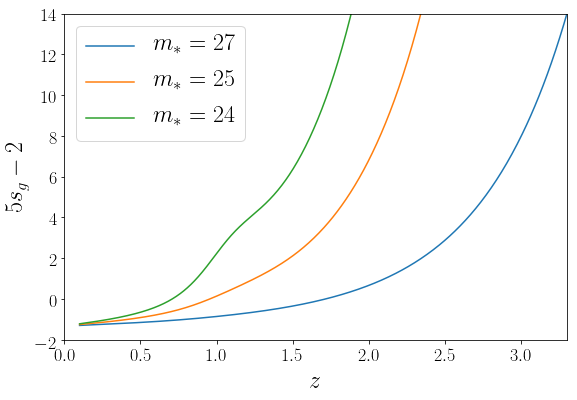

In [4]:
#now plot s :

#different z's to make plot nicer
z = np.linspace(0.1, 3.5, 500)
z2 = np.linspace(0.1, 2.5, 500)
z3 = np.linspace(0.1, 2., 500)


# Ftab = nsig * Ssys(z, CLAR_zhangpen)
# mtab = -2.5 * np.log10(Ftab)

rmax_default = 27 #for LSST
rmax2 = 25
rmax3 = 24
fig = P.figure(figsize = (9,6));
ax2 = fig.add_subplot(111)

# sg1tab = 5*sg(z, MAXMAG = rmax_default)-2
# sg2tab = 5*sg(z2, MAXMAG = rmax2 )-2
# sg3tab = 5*sg(z3, MAXMAG = rmax3 )-2

#TESTING THE INTERPOLATION FUNCTION:
sg1tab = 5*sg_interp(z, MAXMAG = rmax_default)-2
sg2tab = 5*sg_interp(z2, MAXMAG = rmax2 )-2
sg3tab = sg5minus2(z3, rmax3 )



ax2.plot(z, sg1tab, label = r"$m_* = {}$".format(rmax_default))
ax2.plot(z2, sg2tab, label = r"$m_* = {}$".format(rmax2))
ax2.plot(z3, sg3tab, label = r"$m_* = {}$".format(rmax3))




ax2.set_xlabel(r"$z$")
ax2.set_ylabel(r"$5s_g-2$")
ax2.set_ylim((-2, 14))
ax2.set_xlim((0,3.3))


P.legend()
# plotdir = "/Users/amadeus/Documents/PhD/Thesis/tex/images/"
# print "we are saving plot to thesis!!!!"
# P.savefig(plotdir + "alpha.pdf")

Let's quickly check the interpolation for sg:

Using non default rmax = 23.0 for experiment
112 2.238693467336683


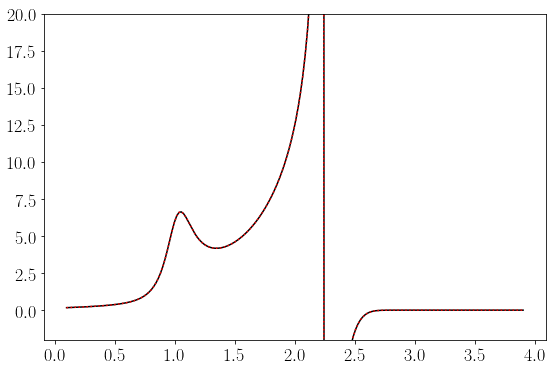

In [5]:
ztab = np.linspace(0.1, 3.9, 200);
rmaxxx = 23.

stab = sg(ztab, MAXMAG=rmaxxx)
stab_2 = sg_interp(ztab, MAXMAG=rmaxxx)



fig = P.figure(); ax = fig.add_subplot(111);
ax.plot(ztab, stab, c = 'black')
ax.plot(ztab, stab_2, c = 'red', ls = ':')
ax.set_ylim((-2,20))

print stab.argmax(), ztab[stab.argmax()]

Now we calculate the galaxy power spectrum and magnification signal:

In [6]:
#Calculate the HI X mag power spectrum Cls:
rmaxtab = [23, 24, 25]
Cl_Hxm_tab_LSST_INTERPOL = [Cl_HIxmag_CAMB(ltab, zf, dzf, zb, dzb, S_G = "LSST_INTERPOL", MAXMAG = rrr) 
                            for rrr in rmaxtab]

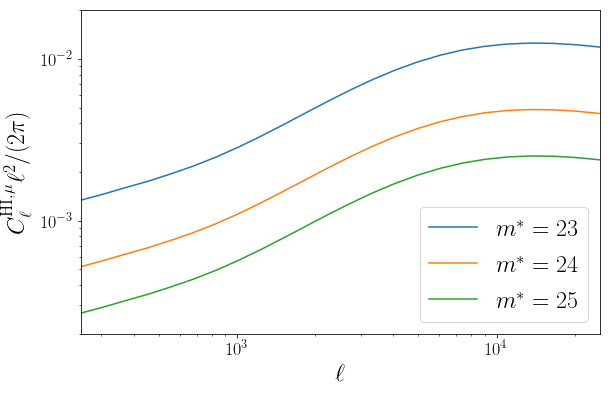

In [7]:
#plot it:
fig = P.figure(); ax = fig.add_subplot(111);

for ri in range(len(rmaxtab)):
    rma = rmaxtab[ri]
    Clll = Cl_Hxm_tab_LSST_INTERPOL[ri]
    ax.loglog(ltab, Clll*ltab**2 / 2 / pi, label = "$m^*={}$".format(rma))


ax.set_xlabel("$\ell$")
ax.set_ylabel("$C_\ell^\mathrm{HI, \mu} \ell^2/(2\pi)$")

ax.set_xlim((250,25000))
ax.set_ylim((2e-4, 2e-2))
# ax.set_ylim((1e-6, 6e-1))
# ax.legend()
P.tight_layout()

P.legend()
# P.savefig(plotdir + "HIxmag_Cls.pdf")



In Z&P the $\ell$ dependece is $C_\ell^{\mu g} \sim \Delta_m^2(\ell/r(z_f), z_f) / l^3$.

For us it's $C_\ell^\mathrm{HI, mag} \sim P((\ell + 1/2)/r(z),z))$.

NOW: signal to noise!!! an example, same foreground redshift bin for HIRAX and SKA:

In [8]:
#make ell table:


# lstart = 10; lend = 20000; 
lstart = 3; lend = 2200; 
# lNN = 1500
# lNN = 300
lNN = 100

ltab = np.unique(np.logspace(np.log10(lstart), np.log10(lend), lNN, dtype = int)) #finer ltab than before
# ltab = np.arange(lstart, lend)

lN = len(ltab)
p_func_list = [C_l_HIHI_CAMB, C_l_gg_CAMB, Cl_HIxmag_CAMB]


In [9]:
# #check the different interferometer noises:

# Nell2 = Cl_interferom_noise_slow(ltab, zf -dzf, zf + dzf, hirax)
# Nell1 = Cl_interferom_noise(ltab, zf - dzf, zf + dzf, hirax)

# fig = P.figure(); ax = fig.add_subplot(111);
# # ax.loglog(ltab, Nell1)
# # ax.loglog(ltab, Nell2, ls = "--")
# ax.semilogx(ltab, Nell2/Nell1)
# ax.set_ylim((0.8,2))
# ax.set_xlabel(r"$\ell$")
# ax.set_ylabel("old noise / new noise")
# P.savefig(plotdir + "noisetest.pdf")

In [10]:
# #without shot noise:
# S2N_SKA = S2N(ltab, zf, dzf, zb, dzb, powspeclist, SURVEY=SKA, MAXMAG = rmax_default)
# S2N_HIRAX = S2N(ltab, zf, dzf, zb, dzb, powspeclist, SURVEY=hirax, MAXMAG = rmax_default)
# # S2N_HIRAX512 = S2N(ltab, zf, dzf, zb, dzb, powspeclist, SURVEY=hirax512, MAXMAG = rmax_default)
# S2N_CV = S2N(ltab, zf, dzf, zb, dzb, powspeclist, SURVEY="CV", MAXMAG = rmax_default)

In [11]:
# #with shot noise:
# S2N_SKA_LSST = S2N(ltab, zf, dzf, zb, dzb, powspeclist, SURVEY=[SKA, LSST], MAXMAG = rmax_default)
# S2N_HIRAX_LSST = S2N(ltab, zf, dzf, zb, dzb, powspeclist, SURVEY=[hirax, LSST], MAXMAG = rmax_default)
# # S2N_HIRAX512_LSST = S2N(ltab, zf, dzf, zb, dzb, powspeclist, SURVEY=[hirax512, LSST], MAXMAG = rmax_default)

In [12]:
# fig = P.figure(figsize = (12,8)); ax1 = fig.add_subplot(111); 

# ax1.semilogx(ltab, S2N_CV, label = r"CV $\times$ CV", color = "grey")
# ax1.semilogx(ltab, S2N_SKA, label = r"SKA $\times$ CV", color = "black")
# ax1.semilogx(ltab, S2N_HIRAX, label = r"HIRAX $\times$ CV", color = "red")

# ax1.semilogx(ltab, S2N_SKA_LSST, label = r"SKA $\times$ LSST", color = "black", ls = "-.")
# ax1.semilogx(ltab, S2N_HIRAX_LSST, label = r"HIRAX $\times$ LSST", color = "red", ls = "-.")
# # ax1.semilogx(ltab, S2N_SKA_LSST, color = "black", ls = "-.")
# # ax1.semilogx(ltab, S2N_HIRAX_LSST, color = "red", ls = "-.")

# ax1.set_ylabel("$C_\ell^{HI,\mu} / \Delta C_\ell^{HI,\mu} $")
# ax1.set_xlabel("$\ell$")
# ax1.legend(loc = "upper left", fontsize = 18)

# ax1.set_ylim((0.1,1.1 * np.nanmax((S2N_HIRAX, S2N_SKA))))
# ax1.set_xlim((7e0, 5e3))

# # plotdir = "/Users/amadeus/Documents/PhD/Thesis/tex/images/"
# # print "we are saving plot to thesis!!!!"
# # P.savefig(plotdir + "S2N.pdf")

Now we use different redshift bins for HIRAX and SKA. For SKA we use B1 and B2, for HIRAX we make smaller bins, but still wider bins than would be used in a real analysis...
In the plot above the S2N for HIRAX is clearly shot noise dominated.

# setting up HIRAX redshift bins:

In [13]:
########################################################################
########################################################################
############WORKING ON HIRAX:####################################



buffer_z = 0.1 #buffer between fg and bg to avoid correlation, 
#we should pick a value more carefully later, according to photo-z measurements

# zbbmax = 3.9 #maximum range of LSST


########################################################################
########################################################################
############MAKING HIRAX REDSHIFT BINS:####################################
########################################################################
########################################################################

numin_HIRAX = 400
numax_HIRAX = 800
zHIRAX_min = nutoz21(numax_HIRAX) # minimum of HIRAX
# zHIRAX_max = nutoz21(400) # maximum of HIRAX
zHIRAX_max = 2. # maximum of HIRAX, more does not make sense otherwise we have no galaxies left to cross correlate with
# dzHIRAX = 0.05
# dzHIRAX = 0.1
dzHIRAX = 0.15
Nstep = np.int((zHIRAX_max - zHIRAX_min) / (2 * dzHIRAX))
print "HIRAX' z range: {} to {}".format(zHIRAX_min, zHIRAX_max)
zHIRAX_allbin, steplen = np.linspace(zHIRAX_min, zHIRAX_max, Nstep, retstep = True) #lower bin edges
zHIRAX_lowbin = zHIRAX_allbin[:-1]
dzHIRAX = steplen/2
zHIRAX_meanbin = zHIRAX_lowbin + dzHIRAX
zHIRAX_highbin = zHIRAX_lowbin + 2*dzHIRAX
NBIN = len(zHIRAX_lowbin)





HIRAX' z range: 0.7755075 to 2.0


# Optimization of m* for each HIRAX redshift bin

In [14]:
########################################################################
########################################################################
# optimize S2N(m*) FOR HIRAX

ltab_HIRAX_opt = np.array([200]) #only one ell for opt

# mstar_H = np.zeros(NBIN)
opti_H = []
guesses = 25 * np.ones(NBIN)
for iz in range(NBIN):
    S2Nargs = (ltab_HIRAX_opt, zHIRAX_lowbin[iz], zHIRAX_highbin[iz], buffer_z, [hirax, LSST], [C_l_HIHI_CAMB, C_l_gg_CAMB, Cl_HIxmag_CAMB])
    opti = optimize.minimize( S2N_for_opt, [guesses[iz]], args = S2Nargs, method='Nelder-Mead', tol = 1e-2, bounds = ((23,27),))
    opti_H.append(opti)

mso_H = [oo['x'] for oo in opti_H] #m star opt = mso


/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/optimize/_minimize.py:518: RuntimeWarning: Method Nelder-Mead cannot handle constraints nor bounds.
  RuntimeWarning)


we assume d_ell = 1
shot noise for LSST!
calculating single dish autocorrelation noise
we assume d_ell = 1
shot noise for LSST!
calculating single dish autocorrelation noise
we assume d_ell = 1
shot noise for LSST!
calculating single dish autocorrelation noise
we assume d_ell = 1
shot noise for LSST!
calculating single dish autocorrelation noise
we assume d_ell = 1
shot noise for LSST!
calculating single dish autocorrelation noise
we assume d_ell = 1
shot noise for LSST!
calculating single dish autocorrelation noise
we assume d_ell = 1
shot noise for LSST!
calculating single dish autocorrelation noise
we assume d_ell = 1
shot noise for LSST!
calculating single dish autocorrelation noise
we assume d_ell = 1
shot noise for LSST!
calculating single dish autocorrelation noise
we assume d_ell = 1
shot noise for LSST!
calculating single dish autocorrelation noise
we assume d_ell = 1
shot noise for LSST!
calculating single dish autocorrelation noise
we assume d_ell = 1
shot noise for LSST!
ca

In [15]:
print mso_H

[array([23.87695312]), array([25.09765625]), array([26.09375])]


# Now calculate the S2N for each HIRAX bin and the respective m*

In [16]:
########################################################################
########################################################################
# CALCULATE S2N FOR HIRAX
S2Nlist_full = [] #1024 dishes HIRAX
S2Nlist_512 = [] #512 dishes HIRAX

ellNL = [] #nonlinear scale according to smith et a. with knl0 = 0.14



for i in range(NBIN):


#     zbbmax_H = zmax_of_MAXMAG(mso_H[i]) #max redshift for optimized m*

    zbmin_H, zbmax_H, zb_H, dzb_H = get_bg_bin_for_fgzmax(zHIRAX_highbin[i], mso_H[i], bufferz = buffer_z)

    
    k_NL = 0.14*(1+zb_H)#background redshift is relevant
    ellNL.append(k_NL * rCom(zb_H))
    
    
    S2Nlist_full.append( S2N_of_mstar_and_zf(mso_H[i], ltab, zHIRAX_lowbin[i], zHIRAX_highbin[i], 
                                             SURVEY = [hirax, LSST], bufferz = buffer_z))
    
    S2Nlist_512.append( S2N_of_mstar_and_zf(mso_H[i], ltab, zHIRAX_lowbin[i], zHIRAX_highbin[i], 
                                             SURVEY = [hirax512, LSST], bufferz = buffer_z))


we assume d_ell = 1
shot noise for LSST!
calculating interferometer noise...
we assume d_ell = 1
shot noise for LSST!
calculating interferometer noise...
we assume d_ell = 1
shot noise for LSST!
calculating interferometer noise...
we assume d_ell = 1
shot noise for LSST!
calculating interferometer noise...
we assume d_ell = 1
shot noise for LSST!
calculating interferometer noise...
we assume d_ell = 1
shot noise for LSST!
calculating interferometer noise...


# SKA b1 and b2 redshift bins

In [17]:
########################################################################
########################################################################
############SETTING UP SKA B1:####################################




#fg:
b1_nutot= 435.              # Total bandwidth of *entire* survey [MHz]
b1_numax= 1015.           # Max. freq. of survey

zmin_b1, zmax_b1, zf_b1, dzf_b1 = get_fg_bin_for_frequency_range(b1_nutot, b1_numax)




############SETTING UP SKA B2:####################################
########################################################################
#######################################################################




#fg:
b2_nutot= 470.          # Total bandwidth of *entire* survey [MHz]
b2_numax= 1420.        # Max. freq. of survey


zmin_b2, zmax_b2, zf_b2, dzf_b2 = get_fg_bin_for_frequency_range(b2_nutot, b2_numax)



# SKA optimization for m*

In [18]:
 ############OPTIMIZE SKA B1 AND B2:####################################
########################################################################
#######################################################################  
    
    
    
ltab_SKA_opt = np.array([100]) #only one ell for opt

opti_SKA = []
guess_b1 = 25

guess_b2 = 23

S2Nargs_b1 = (ltab_SKA_opt, zmin_b1, zmax_b1, buffer_z, [SKA, LSST], [C_l_HIHI_CAMB, C_l_gg_CAMB, Cl_HIxmag_CAMB])
opti_b1 = optimize.minimize( S2N_for_opt, guess_b1, args = S2Nargs_b1, method='Nelder-Mead', tol = 1e-2, bounds = ((23,27),))

S2Nargs_b2 = (ltab_SKA_opt, zmin_b2, zmax_b2, buffer_z, [SKA, LSST], [C_l_HIHI_CAMB, C_l_gg_CAMB, Cl_HIxmag_CAMB])
opti_b2 = optimize.minimize( S2N_for_opt, guess_b2, args = S2Nargs_b2, method='Nelder-Mead', tol = 1e-2, bounds = ((23,27),))

    
mso_b1 = opti_b1['x'] #m star opt = mso
mso_b2 = opti_b2['x'] #m star opt = mso

print mso_b1, mso_b2

we assume d_ell = 1
shot noise for LSST!
calculating single dish autocorrelation noise
we assume d_ell = 1
shot noise for LSST!
calculating single dish autocorrelation noise
we assume d_ell = 1
shot noise for LSST!
calculating single dish autocorrelation noise
we assume d_ell = 1
shot noise for LSST!
calculating single dish autocorrelation noise
we assume d_ell = 1
shot noise for LSST!
calculating single dish autocorrelation noise
we assume d_ell = 1
shot noise for LSST!
calculating single dish autocorrelation noise
we assume d_ell = 1
shot noise for LSST!
calculating single dish autocorrelation noise
we assume d_ell = 1
shot noise for LSST!
calculating single dish autocorrelation noise
we assume d_ell = 1
shot noise for LSST!
calculating single dish autocorrelation noise
we assume d_ell = 1
shot noise for LSST!
calculating single dish autocorrelation noise
we assume d_ell = 1
shot noise for LSST!
calculating single dish autocorrelation noise
we assume d_ell = 1
shot noise for LSST!
ca

# now use the optimized m* for S2N for SKA

In [19]:

#######NOW CALCULATE S2N FOR SKA


#bg:
# zbbmax_b2 = zmax_of_MAXMAG(mso_b2)
zbmin_b2, zbmax_b2, zb_b2, dzb_b2 = get_bg_bin_for_fgzmax(zmax_b2, mso_b2, bufferz = buffer_z)


S2N_SKAb1_LSST = S2N_of_mstar_and_zf(mso_b1, ltab, zmin_b1, zmax_b1, bufferz = buffer_z)
S2N_SKAb2_LSST = S2N_of_mstar_and_zf(mso_b2, ltab, zmin_b2, zmax_b2, bufferz = buffer_z)

S2N_CV_b1 = S2N_of_mstar_and_zf(mso_b1, ltab, zmin_b1, zmax_b1, bufferz = buffer_z, SURVEY = "CV")
S2N_CV_b2 = S2N_of_mstar_and_zf(mso_b2, ltab, zmin_b2, zmax_b2, bufferz = buffer_z, SURVEY = "CV")



we assume d_ell = 1
shot noise for LSST!
calculating single dish autocorrelation noise


magmod.py:817: RuntimeWarning: overflow encountered in exp
  oneover_W_ell = np.exp( ltab**2 * sigb**2) #beam smoothing function.


we assume d_ell = 1
shot noise for LSST!
calculating single dish autocorrelation noise
we assume d_ell = 1
we assume d_ell = 1


# before plotting the S2N we show the optimization of m*:

In [ ]:
#MAKE NICE PLOT FOR S2N(m*) for SKA and HIRAX:
magtab = np.linspace(23,27,20) #an example...


########################################################################
########################################################################
# FOR HIRAX
ltab_HIRAX = np.array([200,500,1000]) #only few ells to speed up



S2N_H = np.zeros((len(magtab), NBIN, len(ltab_HIRAX)))

for im in range(len(magtab)): #magnitude cutoff
    for iz in range(NBIN): #redshift bin of HIRAX
        mm = magtab[im]
        S2N_H_now = S2N_of_mstar_and_zf(mm, ltab_HIRAX, zHIRAX_lowbin[iz], zHIRAX_highbin[iz],
                                        SURVEY = [hirax, LSST], bufferz = buffer_z)
        S2N_H[im,iz,:] = S2N_H_now






ltab_SKA = np.array([20,40,80]) #only few ells to speed up


SKA_b1_LSST_maxmag_arr = np.zeros((len(magtab), len(ltab_SKA)))
SKA_b2_LSST_maxmag_arr = np.zeros((len(magtab), len(ltab_SKA)))


for im in range(len(magtab)):
    mm = magtab[im]
    print "working with maxmag {}".format(mm)


    S2N_b1_now = S2N_of_mstar_and_zf(mm, ltab_SKA, zmin_b1, zmax_b1, bufferz = buffer_z)
    S2N_b2_now = S2N_of_mstar_and_zf(mm, ltab_SKA, zmin_b2, zmax_b2, bufferz = buffer_z)
    
    SKA_b1_LSST_maxmag_arr[im,:] = S2N_b1_now
    SKA_b2_LSST_maxmag_arr[im,:] = S2N_b2_now
    

SKA_b2_LSST_maxmag_arr[SKA_b2_LSST_maxmag_arr<0] *= -1
# SKA_b2_LSST_maxmag_arr[SKA_b2_LSST_maxmag_arr<0]=0



we assume d_ell = 1
shot noise for LSST!
calculating interferometer noise...
we assume d_ell = 1
shot noise for LSST!
calculating interferometer noise...


magmod.py:1019: RuntimeWarning: invalid value encountered in true_divide
  return dnndz / np.trapz(dnndz[::-1], z[::-1])


we assume d_ell = 1
shot noise for LSST!
calculating interferometer noise...
we assume d_ell = 1
shot noise for LSST!
calculating interferometer noise...
we assume d_ell = 1
shot noise for LSST!
calculating interferometer noise...
we assume d_ell = 1
shot noise for LSST!
calculating interferometer noise...
we assume d_ell = 1
shot noise for LSST!
calculating interferometer noise...
we assume d_ell = 1
shot noise for LSST!
calculating interferometer noise...
we assume d_ell = 1
shot noise for LSST!
calculating interferometer noise...
we assume d_ell = 1
shot noise for LSST!
calculating interferometer noise...
we assume d_ell = 1
shot noise for LSST!
calculating interferometer noise...
we assume d_ell = 1
shot noise for LSST!
calculating interferometer noise...
we assume d_ell = 1
shot noise for LSST!
calculating interferometer noise...
we assume d_ell = 1
shot noise for LSST!
calculating interferometer noise...
we assume d_ell = 1
shot noise for LSST!
calculating interferometer noise...

In [ ]:
#MAKE NICE PLOT FOR S2N(m*) for SKA:

#colors for HIRAX:
color_array = np.linspace(0,1, NBIN+2)#+1 because we do not want the grey in set1




cols = ["blue", "purple", "red"]

fig = P.figure(figsize = (9,6)); ax = fig.add_subplot(111);
# ax.plot(magtab, SKA_b1_LSST_maxmag_arr[:,0], c= cols[0], label = r"$\mathrm{SKA~b1}$")
# ax.plot(magtab, SKA_b1_LSST_maxmag_arr[:,1], c=cols[1], label = r"$\mathrm{SKA~b1}$")
ax.plot(magtab, SKA_b1_LSST_maxmag_arr[:,2], c='grey', ls = "--", label = r"$\mathrm{SKA~b1}$")

# ax.plot(magtab, SKA_b2_LSST_maxmag_arr[:,0], c= cols[0], ls = ":", label = r"$\mathrm{SKA~b2}$")
# ax.plot(magtab, SKA_b2_LSST_maxmag_arr[:,1], c=cols[1], ls = ":", label = r"$\mathrm{SKA~b2}$")
# ax.plot(magtab, SKA_b2_LSST_maxmag_arr[:,2], c='black', ls = "--", label = r"$\mathrm{SKA~b2}$")


# ax.axvline(mso_b1, c = 'grey')
# ax.axvline(mso_b2, c= 'black')




for iz in range(NBIN-1):
    ci = color_array[iz]
    zfmax_now = np.around(zHIRAX_meanbin[iz] + dzHIRAX,2)
    zfmin_now = np.around(zHIRAX_meanbin[iz] - dzHIRAX,2)
    for ielll in [0]:


        ax.plot(magtab, S2N_H[:,iz,ielll], c=P.cm.Set1(ci), ls = "-", 
                label = r"$\mathrm{{~HIRAX~}} z_\mathrm{{f}} = {} \mathrm{{~to~}} {}$".format(zfmin_now, zfmax_now))
        
#     ax.axvline( mso_H[iz], c=P.cm.Set1(ci))




# ax.legend(loc = "upper left")
# ax.set_title(r"$\mathrm{SKA~B1~(solid)~and~B2~(dotted)}$")
ax.set_xlabel(r"$m_*$")
ax.set_ylabel("$C_\ell^{HI,\mu} / \Delta C_\ell^{HI,\mu} $")

# plotdir = "./plots/"
# print plotdir
# P.savefig(plotdir + "S2N_of_mstar.pdf")

# and now a quick illustration of the behaviour of the lensing kernel:

In [ ]:
#################
#plot the foreground range and background dndz as well as 5sg-2:

ztab = np.linspace(0.001, 3.9,1000)
# fig = P.figure(); ax= fig.add_subplot(111);
fig, allax = P.subplots(2,1, sharex = True, figsize = (8,8))
ax = allax[0]
ax2 = allax[1]

ymax_now = [] #to set the y limits later

colors = ['black', 'blue', 'green']

rtab = [24,25,27]
for irr in np.arange(len(rtab)):
    rr = rtab[irr]
    
    #set colors and labels:
    c = colors[irr]
    
    if irr == 0:
        axnzlab = r"$n_g$"
        axsglab = r"$5s_g-2$"
    else:
        axnzlab = ""
        axsglab = ""
    
    #bg range for mstar:
#     zbbbmax = zmax_of_MAXMAG(rr)
    zbbbmin_b2, zbbbmax_b2, zbbb_b2, dzbbb_b2 = get_bg_bin_for_fgzmax(zmax_b2, rr, bufferz = buffer_z)
    print "fg bg distance is {}z".format(zbbbmin_b2-zmax_b2)

#     if irr == 2:
    if irr == 2 or irr == 1 or irr == 0:
        for axx in allax:
#             axx.fill_between( np.array( [zbbbmin_b2, zbbbmax_b2]), -10, 100, color = 'blue', alpha = 0.2)
            axx.fill_between( np.array( [zbbbmin_b2, 4.]), -10, 100, color = 'blue', alpha = 0.1)


    Wtab = W_dndz(ztab, zbbbmin_b2, zbbbmax_b2, rr)
    Wtab_outside = W_dndz(ztab, zmin_b2, zbbbmin_b2, rr)
    transition_i = np.abs(ztab - zbmin_b2).argmin()
    norm = Wtab_outside[transition_i]/Wtab[transition_i + 1]
    print Wtab_outside[transition_i],Wtab[transition_i]
    Wtab_outside /= norm

    ax.plot(ztab[transition_i+1:], Wtab[transition_i+1:], c = c, label = axnzlab)
    ax.plot(ztab[:transition_i], Wtab_outside[:transition_i],c = c, ls = ":")

    Woutmax = np.amax(Wtab_outside)
    Wmax = np.amax(Wtab)
    ymax_now.append( np.amax((Woutmax, Wmax)) )
    
    #background redshift only:
    zbtab = np.linspace(zbbbmin_b2, zbbbmax_b2, 200)
    sgtab = sg5minus2(zbtab, rr )
    
    ax.plot(zbtab, sgtab, c = c, ls = "--", label = axsglab)
    
    Wtab_inside = W_dndz(zbtab, zbbbmin_b2, zbbbmax_b2, rr)
    ax2.plot(zbtab, Wtab_inside * sgtab, c=c, label = r"$m^* = {}$".format(rr))


#fg redshift range:
ax.fill_between( np.array( [zmin_b2, zmax_b2]), -10, 100, color = 'red', alpha = 0.2)
ax2.fill_between( np.array( [zmin_b2, zmax_b2]), -10, 100, color = 'red', alpha = 0.2)

#horizontal line at 0 for ax2:
ax2.axhline(0, c = 'black', lw = 0.4)

ymax = np.amax(ymax_now)
ax.set_ylim((-1,ymax*1.1))
ax2.set_ylim((-2,2.2))

ax2.set_xlabel(r"$z$")
ax2.set_ylabel(r"$n_g (5s_g-2)$")

ax.legend(loc = "upper right")
ax2.legend(loc = "upper right")

# plotdir = "./plots/"

# P.savefig( plotdir + "W_and_sg_SKAB2.pdf")

# main plot S2N:

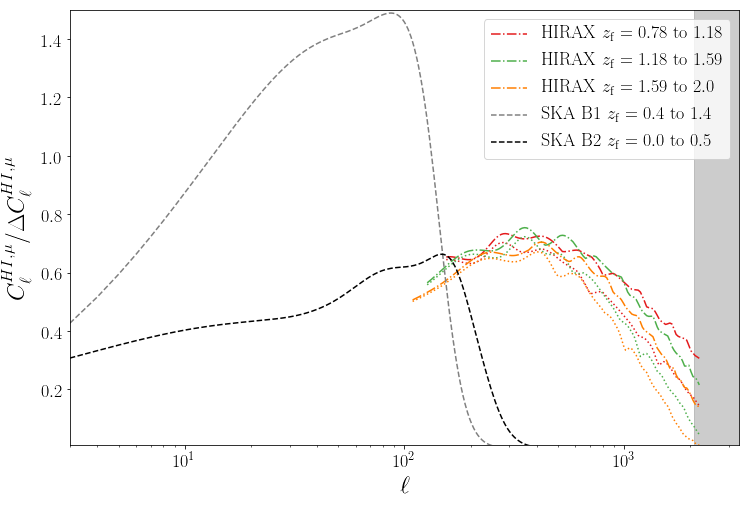

In [23]:
#plotting HIRAX and SKA for different binnings:

fig = P.figure(figsize = (12,8)); ax1 = fig.add_subplot(111); 



for i in range(NBIN):
    ci = color_array[i]
    zfmax_now = np.around(zHIRAX_meanbin[i] + dzHIRAX,2)
    zfmin_now = np.around(zHIRAX_meanbin[i] - dzHIRAX,2)
    
    plotcond = (S2Nlist_full[i] > 1e-5)
    plotcond512 = (S2Nlist_512[i] > 1e-5)
    ax1.semilogx(ltab[plotcond], S2Nlist_full[i][plotcond], 
                 label = r"$\mathrm{{~HIRAX~}} z_\mathrm{{f}} = {} \mathrm{{~to~}} {}$".format(zfmin_now, zfmax_now),
                 color=P.cm.Set1(ci), ls = "-.")
    ax1.semilogx(ltab[plotcond512], S2Nlist_512[i][plotcond512], 
                 color=P.cm.Set1(ci), ls = ":")
#     ax1.semilogx(ltab, S2N_CVlist[i], ls = "-", 
#                  color=P.cm.Set1(ci))
#     ax1.axvline(ellNL[i],
#                color=P.cm.Set1(ci))



ax1.fill_between( np.array( [ellNL[0],ellNL[-1] ]), -10, 100, color = 'grey', alpha = 0.4)
# ax1.semilogx(ltab, S2N_CVlist[0], ls = "-", color='black')
#SKA:
ax1.semilogx(ltab, S2N_SKAb1_LSST, 
             label = r"$\mathrm{{SKA~B1~}} z_\mathrm{{f}} = {} \mathrm{{~to~}} {}$".format(np.around(zmin_b1,1), np.around(zmax_b1,1)), color = "grey", ls = "--")
# ax1.semilogx(ltab, S2N_CV_b1, color = "grey", ls = "-")

ax1.semilogx(ltab, S2N_SKAb2_LSST, label = r"$\mathrm{{SKA~B2~}} z_\mathrm{{f}} = {} \mathrm{{~to~}} {}$".format(np.around(zmin_b2,1), np.around(zmax_b2,1)), color = "black", ls = "--")
# ax1.semilogx(ltab, S2N_CV_b2, color = "black", ls = "-")

    
ax1.set_ylabel("$C_\ell^{HI,\mu} / \Delta C_\ell^{HI,\mu} $")
ax1.set_xlabel("$\ell$")
ax1.legend(loc = "upper right", fontsize = 18)
# ax1.set_ylim((0,50))
ax1.set_ylim((0.01,1.5))
ax1.set_xlim((3e0, ellNL[-1]))
# plotdir = "/Users/amadeus/Documents/PhD/Oxford/pres10min2/"

plotdir = "/Users/amadeus/Documents/PhD/Thesis/tex/images/"
# print "we are saving plot to thesis!!!!"

# P.savefig(plotdir + "S2N_SKA_HIRAX.pdf")

# cumulative S2N:

In [24]:
NL = len(ltab)
SKA_b1_cum = np.sqrt( np.cumsum(S2N_SKAb1_LSST**2))
SKA_b2_cum = np.sqrt( np.cumsum(S2N_SKAb2_LSST**2))
HIRAX_cum = []
HIRAX512_cum = []
for i in range(NBIN):
    HIR = np.cumsum( S2Nlist_full[i]**2)
    HIR512 = np.cumsum( S2Nlist_512[i]**2)
    HIRAX_cum.append(np.sqrt(HIR))
    HIRAX512_cum.append(np.sqrt(HIR512))


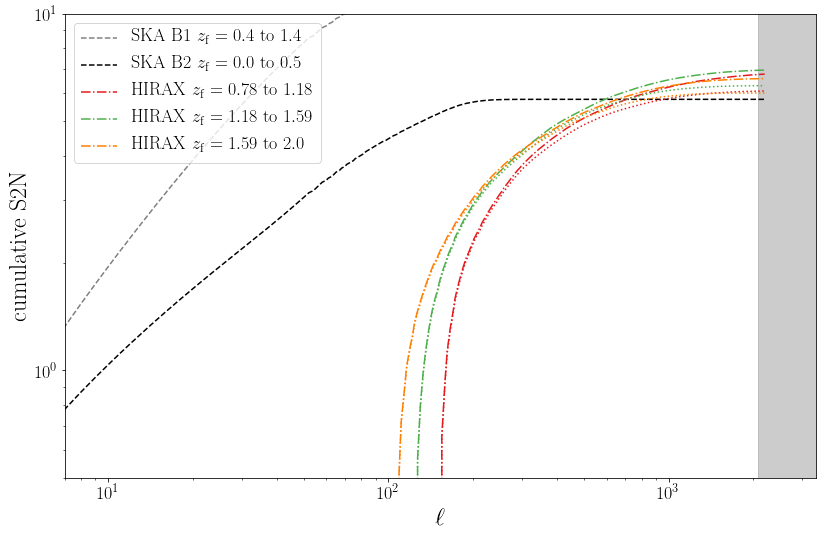

In [25]:
fig = P.figure(figsize = (12,8)); ax= fig.add_subplot(111);

# ax.semilogx(ltab, SKA_b1_cum,
#             label = "SKA b1 zf = {} to {}".format(np.around(zmin_b1,1), np.around(zmax_b1,1)), 
#             color = "grey", ls = "-.")
# ax.semilogx(ltab, SKA_b2_cum, label = "SKA b2 zf = {} to {}".format(np.around(zmin_b2,1), np.around(zmax_b2,1)), 
#             color = "black", ls = "-.")

# ax.fill_between( np.array( [ellNL[0],ellNL[-1] ]), -10, 1000, color = 'grey', alpha = 0.4)

# for i in range(NBIN):
#     ci = color_array[i]
#     zfmax_now = np.around(zHIRAX_meanbin[i] + dzHIRAX,2)
#     zfmin_now = np.around(zHIRAX_meanbin[i] - dzHIRAX,2)
#     ax.semilogx(ltab, HIRAX_cum[i],
#                label = "zf = {} to {}".format(zfmin_now, zfmax_now),
#                  color=P.cm.Set1(ci), ls = "-.")
#     ax.semilogx(ltab, HIRAX512_cum[i], color=P.cm.Set1(ci), ls = ":")


ax.loglog(ltab, SKA_b1_cum,
            label = r"$\mathrm{{SKA~B1~}} z_\mathrm{{f}} = {} \mathrm{{~to~}} {}$".format(np.around(zmin_b1,1), np.around(zmax_b1,1)), 
            color = "grey", ls = "--")
ax.loglog(ltab, SKA_b2_cum, label = r"$\mathrm{{SKA~B2~}} z_\mathrm{{f}} = {} \mathrm{{~to~}} {}$".format(np.around(zmin_b2,1), np.around(zmax_b2,1)), 
            color = "black", ls = "--")

ax.fill_between( np.array( [ellNL[0],ellNL[-1] ]), -10, 1000, color = 'grey', alpha = 0.4)

for i in range(NBIN):
    ci = color_array[i]
    zfmax_now = np.around(zHIRAX_meanbin[i] + dzHIRAX,2)
    zfmin_now = np.around(zHIRAX_meanbin[i] - dzHIRAX,2)
    ax.loglog(ltab, HIRAX_cum[i],
               label = r"$\mathrm{{~HIRAX~}} z_\mathrm{{f}} = {} \mathrm{{~to~}} {}$".format(zfmin_now, zfmax_now),
                 color=P.cm.Set1(ci), ls = "-.")
    ax.loglog(ltab, HIRAX512_cum[i], color=P.cm.Set1(ci), ls = ":")


ax.set_xlabel(r"$\ell$")
ax.set_ylabel(r"$\mathrm{cumulative~S2N}$")
ax.legend(loc = "upper left", fontsize = 18)
# ax.set_ylim((-1,180))
ax.set_ylim((5e-1,10))
ax.set_xlim((7e0,ellNL[-1]))

P.tight_layout()
# P.savefig(plotdir + "S2N_SKA_HIRAX_CUM.pdf")



# --Check the noise calculations!

To check the noise here are a few plots that show the different contributions:

In [26]:
#first make new zf:


zf = 1.1
dzf = 0.25
zmin = zf-dzf
zmax = zf+dzf



print "foreground from {} to {}".format(zf-dzf, zf+dzf)


foreground from 0.85 to 1.35


In [27]:
# optimize for HIRAX and SKA in these redshift bins:


ltab_SKA_fornoise_opt = np.array([100]) #only one ell for opt
ltab_H_fornoise_opt = np.array([200]) #only one ell for opt

opti_SKA_fornoise = []
opti_H_fornoise = []
guess_fornoise = 25

S2Nargs_SKA_fornoise = (ltab_SKA_fornoise_opt, zmin, zmax, buffer_z, [SKA, LSST], [C_l_HIHI_CAMB, C_l_gg_CAMB, Cl_HIxmag_CAMB])
opti_SKA_fornoise = optimize.minimize( S2N_for_opt, guess_fornoise, args = S2Nargs_SKA_fornoise, method='Nelder-Mead', tol = 1e-2, bounds = ((23,27),))

S2Nargs_H_fornoise = (ltab_H_fornoise_opt, zmin, zmax, buffer_z, [hirax, LSST], [C_l_HIHI_CAMB, C_l_gg_CAMB, Cl_HIxmag_CAMB])
opti_H_fornoise = optimize.minimize( S2N_for_opt, guess_fornoise, args = S2Nargs_H_fornoise, method='Nelder-Mead', tol = 1e-2, bounds = ((23,27),))

    
mso_SKA_fornoise = opti_SKA_fornoise['x'] #m star opt = mso
mso_H_fornoise = opti_H_fornoise['x'] #m star opt = mso


we assume d_ell = 1
shot noise for LSST!
calculating single dish autocorrelation noise
we assume d_ell = 1
shot noise for LSST!
calculating single dish autocorrelation noise
we assume d_ell = 1
shot noise for LSST!
calculating single dish autocorrelation noise
we assume d_ell = 1
shot noise for LSST!
calculating single dish autocorrelation noise
we assume d_ell = 1
shot noise for LSST!
calculating single dish autocorrelation noise
we assume d_ell = 1
shot noise for LSST!
calculating single dish autocorrelation noise
we assume d_ell = 1
shot noise for LSST!
calculating single dish autocorrelation noise
we assume d_ell = 1
shot noise for LSST!
calculating single dish autocorrelation noise
we assume d_ell = 1
shot noise for LSST!
calculating single dish autocorrelation noise
we assume d_ell = 1
shot noise for LSST!
calculating single dish autocorrelation noise
we assume d_ell = 1
shot noise for LSST!
calculating single dish autocorrelation noise
we assume d_ell = 1
shot noise for LSST!


KeyboardInterrupt: 

In [ ]:
print mso_H_fornoise, mso_SKA_fornoise

In [ ]:
#look at different error contributions

#get bg redshift:
zbmin_SKA_fornoise, zbmax_SKA_fornoise, zb_SKA_fornoise, dzb_SKA_fornoise = get_bg_bin_for_fgzmax(zmax, mso_SKA_fornoise, bufferz = buffer_z)
zbmin_H_fornoise, zbmax_H_fornoise, zb_H_fornoise, dzb_H_fornoise = get_bg_bin_for_fgzmax(zmax, mso_H_fornoise, bufferz = buffer_z)

print "SKA background from {} to {}".format(zbmin_SKA_fornoise, zbmax_SKA_fornoise)
print "HIRAX background from {} to {}".format(zbmin_H_fornoise, zbmax_H_fornoise)

powspeclist_SKA = [p_func_list[0](ltab, zfmin, zfmax),
               p_func_list[1](ltab, zbmin_SKA_fornoise, zbmax_SKA_fornoise, mso_SKA_fornoise),
               p_func_list[2](ltab, zf, dzf, zb_SKA_fornoise, dzb_SKA_fornoise, MAXMAG = mso_SKA_fornoise)]

powspeclist_H = [p_func_list[0](ltab, zfmin, zfmax),
               p_func_list[1](ltab, zbmin_H_fornoise, zbmax_H_fornoise, mso_H_fornoise),
               p_func_list[2](ltab, zf, dzf, zb_H_fornoise, dzb_H_fornoise, MAXMAG = mso_H_fornoise)]



#first get the 3 different signals:
#for HIRAX:
Xsignal_H = powspeclist_H[2]
hsignal_H = powspeclist_H[0]
gsignal_H = powspeclist_H[1]

# for SKA
Xsignal_S = powspeclist_SKA[2]
hsignal_S = powspeclist_SKA[0]
gsignal_S = powspeclist_SKA[1]

In [ ]:
#now for CV
cverr_H = DELTA_Cl_HIxmag(ltab, zf, dzf, zb_H_fornoise, dzb_H_fornoise, powspeclist_H, SURVEY = "CV", MAXMAG = mso_H_fornoise)
cverr_S = DELTA_Cl_HIxmag(ltab, zf, dzf, zb_SKA_fornoise, dzb_SKA_fornoise, powspeclist_SKA, SURVEY = "CV", MAXMAG = mso_SKA_fornoise)
#for HIRAX
HIRAXerr = DELTA_Cl_HIxmag(ltab, zf, dzf, zb_H_fornoise, dzb_H_fornoise, powspeclist_H, SURVEY = [hirax, LSST], MAXMAG = mso_H_fornoise)
#for SKA:
SKAerr = DELTA_Cl_HIxmag(ltab, zf, dzf, zb_SKA_fornoise, dzb_SKA_fornoise, powspeclist_SKA, SURVEY = [SKA, LSST], MAXMAG = mso_SKA_fornoise)

#LSST shot noise:
LSSTshot_H = shotnoise(zb_H_fornoise, dzb_H_fornoise, LSST, NINT = 200, MAXMAG = mso_H_fornoise)
LSSTshot_S = shotnoise(zb_SKA_fornoise, dzb_SKA_fornoise, LSST, NINT = 200, MAXMAG = mso_SKA_fornoise)

#HIRAX N_ell
HIRAXNell = Cl_interferom_noise(ltab,zfmin,zfmax, hirax)

#SKA N_ell
SKANell = noise_cls_single_dish(ltab, ztonu21(zf), SKA, 256)

In [ ]:
print "The error plots have redshifts {} to {} for foregrounds, and {} to {} for backgrounds.".format(zf-dzf, 
                                                                                                      zf+dzf,
                                                                                                     zb-dzb,
                                                                                                     zb+dzb)

In [ ]:
fsky_hirax = hirax["S_area"] /4/np.pi
fsky_SKA = SKA["S_area"] /4/np.pi


####cosmic variances:

SKACV_factor = np.sqrt(2)/np.sqrt((2*ltab + 1) * fsky_SKA)
HIRAXCV_factor = np.sqrt(2)/np.sqrt((2*ltab + 1) * fsky_hirax)
#cross:
XCVSKA = np.sqrt(Xsignal_S**2 + hsignal_S * gsignal_S) * SKACV_factor
XCVHIRAX = np.sqrt(Xsignal_H**2 + hsignal_H * gsignal_H) *HIRAXCV_factor
#HI:
HICVSKA = hsignal_S * SKACV_factor
HICVHIRAX = hsignal_H * HIRAXCV_factor
#gal:
GCVSKA = gsignal_S * SKACV_factor
GCVHIRAX = gsignal_H * HIRAXCV_factor

#noise contribution in the cross power spectrum:
XnoiseSKA = np.sqrt(hsignal_S*LSSTshot_S + gsignal_S*SKANell + LSSTshot_S*SKANell)
XnoiseHIRAX = np.sqrt(hsignal_H*LSSTshot_H + gsignal_H*HIRAXNell + LSSTshot_H*HIRAXNell)

In [ ]:
#first all for HI,HI power spectrum:

fig = P.figure(figsize = (12,8)); ax = fig.add_subplot(111);
ax.loglog(ltab, hsignal_H, label = r"$C_\ell^\mathrm{HI-HI}$")

ax.loglog(ltab, (hsignal_H + HIRAXNell) * HIRAXCV_factor, label = r"$\Delta C_\ell^\mathrm{HI-HI} \mathrm{~HIRAX} $", color = "grey")
ax.loglog(ltab, HIRAXNell * HIRAXCV_factor, label = r"$\Delta^\mathrm{HI-HI}_{N_\ell}\mathrm{~HIRAX}$", color = "grey", ls = "-.")
ax.loglog(ltab, HICVHIRAX, label = r"$\Delta^\mathrm{HI-HI}_\mathrm{CV}\mathrm{~HIRAX}$", color = 'grey', ls = "--")


ax.loglog(ltab, (hsignal_S + SKANell) * SKACV_factor, label = r"$ \Delta C_\ell^\mathrm{HI-HI} \mathrm{~SKA}$", color = 'red')
ax.loglog(ltab, SKANell * SKACV_factor, label = r"$\Delta^\mathrm{HI-HI}_{N_\ell} \mathrm{~SKA}$", color = "red", ls = "-.")
ax.loglog(ltab, HICVSKA, label = r"$\Delta^\mathrm{HI-HI}_\mathrm{CV} \mathrm{~SKA}$", color = 'red', ls = "--")

ax.set_ylim((6e-11,2e-7))
ax.set_xlim((3e0, 2.3e3))

ax.set_xlabel(r"$\ell$")
P.legend(fontsize = 18, loc = "upper right")
P.tight_layout()

# P.savefig(plotdir + "HIHI_error_contributions.pdf")

In [ ]:
#now for galaxies:

fig = P.figure(figsize = (9,6)); ax = fig.add_subplot(111);
ax.loglog(ltab, gsignal_H, label = r"$C_\ell^\mathrm{g-g}$")

ax.loglog(ltab, (gsignal_H + LSSTshot_H) * HIRAXCV_factor, label = r"$\Delta C_\ell^\mathrm{g-g}$", color = "magenta")
ax.loglog(ltab, LSSTshot_H * HIRAXCV_factor, label = r" $\Delta^\mathrm{g-g}_\mathrm{shot}$", color = "magenta", ls = "-.")
ax.loglog(ltab, GCVHIRAX, label = r"$\Delta^\mathrm{g-g}_\mathrm{CV}$", color = 'magenta', ls = "--")


# ax.loglog(ltab, gsignal_S, label = r"$C_\ell^\mathrm{g-g}$")

# ax.loglog(ltab, (gsignal_S + LSSTshot_S) * SKACV_factor, label = r"$\Delta C_\ell^\mathrm{g-g}$", color = "cyan")
# ax.loglog(ltab, LSSTshot_S * SKACV_factor, label = r" $\Delta^\mathrm{g-g}_\mathrm{shot}$", color = "cyan", ls = "-.")
# ax.loglog(ltab, GCVSKA, label = r"$\Delta^\mathrm{g-g}_\mathrm{CV}$", color = 'cyan', ls = "--")




ax.set_ylim((5e-8, 1e-5))
ax.set_xlabel(r"$\ell$")
P.legend(loc = "upper right", fontsize = 18)
P.tight_layout()

# P.savefig(plotdir + "GG_error_contributions.pdf")

In [ ]:
#last but not least the HIxmag power spectrum:

Hnoisecond = (HIRAXerr < 1e-3) 


fig = P.figure(figsize = (11,7)); ax = fig.add_subplot(111);
ax.loglog(ltab, Xsignal_H, label = r"$C_\ell^{\mathrm{HI-}\mu}$", color = 'blue')
ax.loglog(ltab, Xsignal_S, color = 'blue')
ax.fill_between(ltab, Xsignal_H, Xsignal_S, color= 'blue', alpha = 0.2)

ax.loglog(ltab[Hnoisecond], HIRAXerr[Hnoisecond], label = r"$\Delta C_\ell^{\mathrm{HI-} \mu} \mathrm{~HIRAX} $", color = "grey")
# ax.loglog(ltab, XnoiseHIRAX * HIRAXCV_factor, label = r"$\Delta^{\mathrm{HI-} \mu}_{\mathrm{shot,~}N_\ell} \mathrm{~HIRAX}$", color = "grey", ls = "-.")
ax.loglog(ltab, XCVHIRAX, label = r"$\Delta_\mathrm{CV}^{\mathrm{HI-} \mu} \mathrm{~HIRAX} $", color = 'grey', ls = "--")


ax.loglog(ltab, SKAerr, label = r"$\Delta C_\ell^{\mathrm{HI-} \mu} \mathrm{~SKA} $", color = 'red')
ax.loglog(ltab, XnoiseSKA * SKACV_factor, label = r"$\Delta^{\mathrm{HI-} \mu}_{\mathrm{shot,~}N_\ell} \mathrm{~SKA}$", color = "red", ls = "-.")
ax.loglog(ltab, XCVSKA, label = r"$\Delta_\mathrm{CV}^{\mathrm{HI-} \mu} \mathrm{~SKA} $", color = 'red', ls = "--")

ax.set_xlabel(r"$\ell$")
P.legend(fontsize = 18, loc = "upper right")
ax.set_ylim((2e-9,1e-6))
ax.set_xlim((3e0, 2.3e3))

P.tight_layout()
# P.savefig(plotdir + "X_error_contributions.pdf")